# Nvidia Daily Stock Price Forecasting

## Import dependencies

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Data

In [2]:
# Set start and end dates
start_date = datetime.datetime(2013, 4, 1)
end_date = datetime.datetime(2020, 3, 1)

In [3]:
# Define a dictionary with the ticker symbols and asset names
tickers = {
    "NVDA": "NVIDIA Corporation",
    "^GSPC": "S&P 500",
    "^TNX": "10-Year US Government Bond"
}

In [4]:
# Create an empty DataFrame to store the data
df_prices = pd.DataFrame()
df_returns = pd.DataFrame()

In [5]:
# Define the desired frequency (daily, weekly, monthly)
frequency = "1d"  # "1d" for daily, "1wk" for weekly, "1mo" for monthly

# Fetch the data from Yahoo Finance using yfinance for daily prices
df_daily_prices = yf.download(list(tickers.keys()), start=start_date, end=end_date, interval=frequency)["Close"]

# Calculate the log returns for daily prices
df_daily_log_returns = np.log(df_daily_prices / df_daily_prices.shift(1))

# Drop na values
df_daily_prices = df_daily_prices.dropna()
df_daily_log_returns = df_daily_log_returns.dropna()

[*********************100%***********************]  3 of 3 completed


## Plot Stock Price and Log Return Series

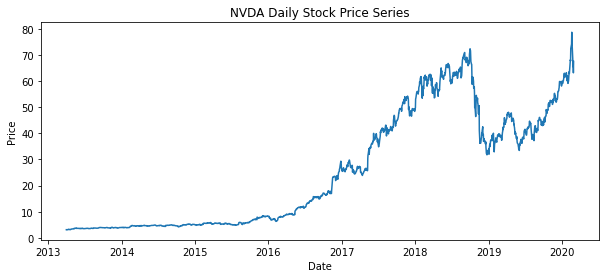

In [6]:
# Plot the price series of NVDA
plt.figure(figsize=(10, 4))
plt.plot(df_daily_prices.index, df_daily_prices["NVDA"])
plt.title("NVDA Daily Stock Price Series")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

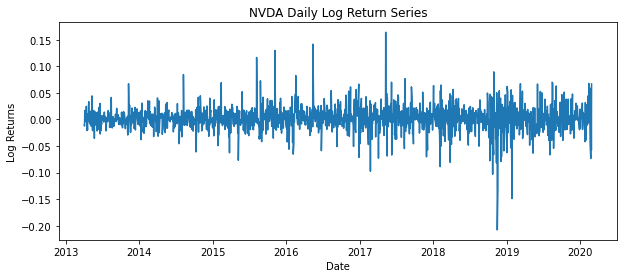

In [7]:
# Plot the log returns of NVDA
plt.figure(figsize=(10, 4))
plt.plot(df_daily_log_returns.index, df_daily_log_returns["NVDA"])
plt.title("NVDA Daily Log Return Series")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.show()

## ACF and PACF

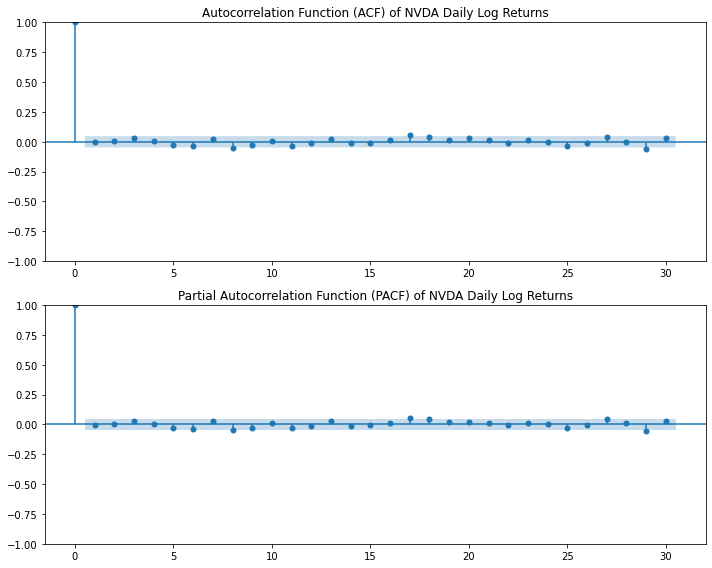

In [8]:
# Plot the ACF and PACF of NVDA log returns
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# ACF plot
plot_acf(df_daily_log_returns["NVDA"], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) of NVDA Daily Log Returns")

# PACF plot
plot_pacf(df_daily_log_returns["NVDA"], ax=ax[1], lags=30)
ax[1].set_title("Partial Autocorrelation Function (PACF) of NVDA Daily Log Returns")

plt.tight_layout()
plt.show()

## LSTM Model Construction

### Data Preprocessing

In [9]:
# Create a new scaler for each dataset, we will need these later for inverse_transform
price_scaler = MinMaxScaler(feature_range=(0, 1))
returns_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler objects to the dataframes and transform
df_daily_prices_scaled = pd.DataFrame(price_scaler.fit_transform(df_daily_prices), columns=df_daily_prices.columns)
df_daily_log_returns_scaled = pd.DataFrame(returns_scaler.fit_transform(df_daily_log_returns), columns=df_daily_log_returns.columns)

### Create Sequences

In [10]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # choose sequence length
X_price, y_price = create_sequences(df_daily_prices_scaled.values, seq_length)
X_returns, y_returns = create_sequences(df_daily_log_returns_scaled.values, seq_length)

### Train / Test Split

In [11]:
train_size = int(len(X_price) * 0.8)
test_size = len(X_price) - train_size
trainX_price, testX_price = X_price[0:train_size], X_price[train_size:len(X_price)]
trainY_price, testY_price = y_price[0:train_size], y_price[train_size:len(y_price)]
trainX_returns, testX_returns = X_returns[0:train_size], X_returns[train_size:len(X_returns)]
trainY_returns, testY_returns = y_returns[0:train_size], y_returns[train_size:len(y_returns)]

### Build LSTM Model

In [12]:
model_price = load_model('model_price.h5')
model_returns = load_model('model_returns.h5')

### Make Predictions

In [13]:
# Make predictions
trainPredict_price = model_price.predict(trainX_price)
testPredict_price = model_price.predict(testX_price)
trainPredict_returns = model_returns.predict(trainX_returns)
testPredict_returns = model_returns.predict(testX_returns)

11/11 [==============================] - 0s 6ms/step


In [14]:
# Make dummy arrays
trainPredict_price_dummy = np.zeros(shape=(len(trainPredict_price), df_daily_prices.shape[1]))
testPredict_price_dummy = np.zeros(shape=(len(testPredict_price), df_daily_prices.shape[1]))
trainPredict_returns_dummy = np.zeros(shape=(len(trainPredict_returns), df_daily_log_returns.shape[1]))
testPredict_returns_dummy = np.zeros(shape=(len(testPredict_returns), df_daily_log_returns.shape[1]))

# Place the predictions into the dummy arrays
trainPredict_price_dummy[:,0] = trainPredict_price[:,0]
testPredict_price_dummy[:,0] = testPredict_price[:,0]
trainPredict_returns_dummy[:,0] = trainPredict_returns[:,0]
testPredict_returns_dummy[:,0] = testPredict_returns[:,0]

# Inverse transform the predictions
trainPredict_price = price_scaler.inverse_transform(trainPredict_price_dummy)[:,0]
testPredict_price = price_scaler.inverse_transform(testPredict_price_dummy)[:,0]
trainPredict_returns = returns_scaler.inverse_transform(trainPredict_returns_dummy)[:,0]
testPredict_returns = returns_scaler.inverse_transform(testPredict_returns_dummy)[:,0]


### Assess Performance

In [15]:
true_values = df_daily_prices['NVDA'][-len(testPredict_price):].values
predictions = testPredict_price.flatten()

# Calculate the errors
errors = true_values - predictions

# Calculate and print each metric
mse = mean_squared_error(true_values, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

mae = mean_absolute_error(true_values, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mape = np.mean(np.abs(errors / true_values)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Mean Squared Error (MSE): 77.72445009938762
Root Mean Squared Error (RMSE): 8.816147123283937
Mean Absolute Error (MAE): 7.661710312751874
Mean Absolute Percentage Error (MAPE): 17.467520318194826%


### Visualise Results

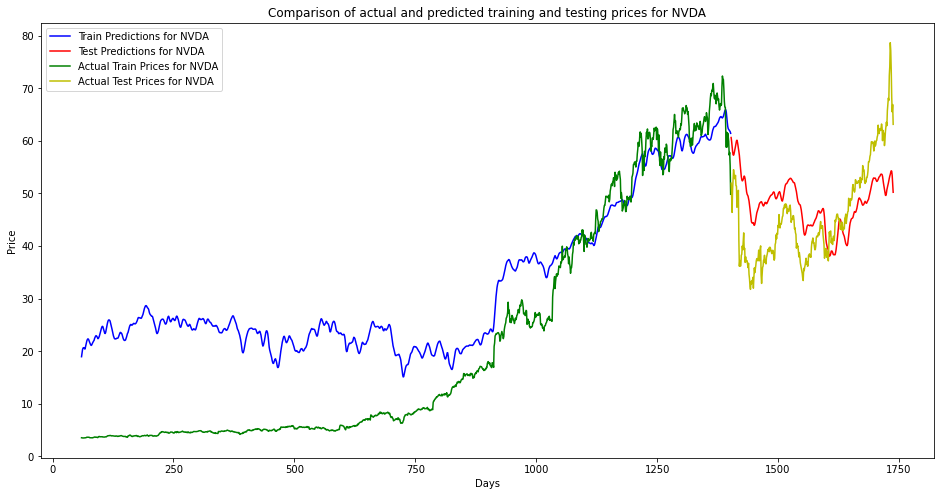

In [16]:
plt.figure(figsize=(16,8))

# The time at which to split the plots between train and test
split_pt = train_size + seq_length 

# Predicted data
plt.plot(np.arange(seq_length, split_pt, 1), trainPredict_price, color='b', label='Train Predictions for NVDA')
plt.plot(np.arange(split_pt, split_pt + len(testPredict_price), 1), testPredict_price, color='r', label='Test Predictions for NVDA')

# Actual data
plt.plot(np.arange(seq_length, split_pt, 1), df_daily_prices.iloc[seq_length:split_pt, 0], color='g', label='Actual Train Prices for NVDA')
plt.plot(np.arange(split_pt, split_pt + len(testPredict_price), 1), df_daily_prices.iloc[split_pt:split_pt + len(testPredict_price), 0], color='y', label='Actual Test Prices for NVDA')

plt.title('Comparison of actual and predicted training and testing prices for NVDA')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()


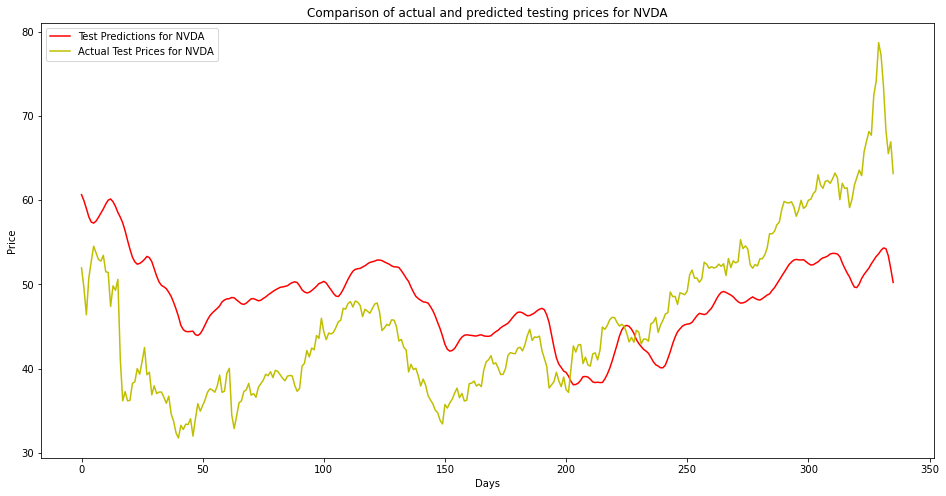

In [17]:
plt.figure(figsize=(16,8))

# Test period start point
split_pt = train_size + seq_length 

# Predicted data
plt.plot(np.arange(0, len(testPredict_price), 1), testPredict_price, color='r', label='Test Predictions for NVDA')

# Actual data
plt.plot(np.arange(0, len(testPredict_price), 1), df_daily_prices.iloc[split_pt:split_pt + len(testPredict_price), 0], color='y', label='Actual Test Prices for NVDA')

plt.title('Comparison of actual and predicted testing prices for NVDA')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()


## Trading Strategy

In [18]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


In [19]:
model_price = Sequential([
    LSTM(50, activation='relu', input_shape=(trainX_price.shape[1], 3), return_sequences=True),
    MCDropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    MCDropout(0.2),
    Dense(1)
])


In [20]:
n_predictions = 100
predictions = np.zeros((n_predictions, len(testX_price)))
for i in range(n_predictions):
    predictions[i] = model_price.predict(testX_price).flatten()


11/11 [==============================] - 0s 7ms/step


In [21]:
predicted_mean = predictions.mean(axis=0)
predicted_std = predictions.std(axis=0)


In [22]:
# Get the number of data points in the test set
test_length = len(df_daily_prices) - (train_size + seq_length - 1)

# Calculate the predicted changes and prices for the test set
predicted_changes = predicted_mean
predicted_prices = df_daily_prices['NVDA'][-(test_length-2):].values + predicted_changes

# Determine the positions based on the predicted changes
positions = np.sign(predicted_changes)

# Use the standard deviation of the predictions as a measure of confidence
confidence = 1 - predicted_std

# Scale the positions by the confidence
positions = positions * confidence

# Calculate the actual changes in price
actual_changes = df_daily_prices['NVDA'][-(test_length-2):].values - df_daily_prices['NVDA'][-(test_length-2)-1:-1].values

# The strategy's daily returns are the product of the positions and the actual changes in price
strategy_returns = positions[:-1] * actual_changes[1:]


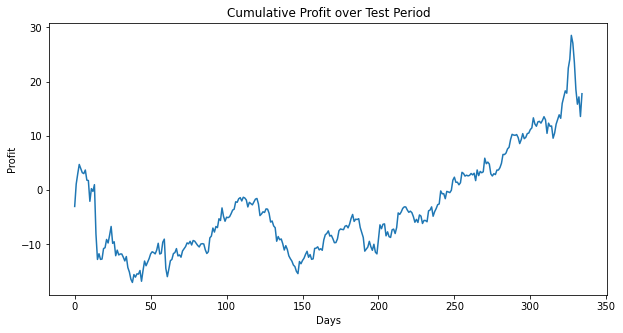

In [23]:
# Calculate the cumulative profit
cumulative_profit = np.cumsum(strategy_returns)

# Create a plot
plt.figure(figsize=(10,5))

# Plot the cumulative profit over time
plt.plot(cumulative_profit)

plt.title('Cumulative Profit over Test Period')
plt.xlabel('Days')
plt.ylabel('Profit')
plt.show()
